In [13]:
# Import
from jianzhi.language_classifier.file_deal import *
from jianzhi.language_classifier.word_cut import *
from jianzhi.language_classifier.x_generate import *
from jianzhi.language_classifier.classifier import *
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
import json

In [2]:
# 数据的清洗、格式化，生成DF
path = 'C:/Users/yangyujie8/PycharmPr' \
       'ojects/deep_learning/jianzhi/data/language_classifier_data/all_files'
get_file('js', 
         'C:/Users/yangyujie8/PycharmProjects/deep_learning/'
         'jianzhi/data/language_classifier_data/node-master', 
         path)
get_file('py', 
         'C:/Users/yangyujie8/PycharmProjects/deep_learning/'
         'jianzhi/data/language_classifier_data/cpython-master', 
         path)
get_file('c', 
         'C:/Users/yangyujie8/PycharmProjects/deep_learning/'
         'jianzhi/data/language_classifier_data/linux-master', 
         path)
get_file('java', 
         'C:/Users/yangyujie8/PycharmProjects/deep_learning/'
         'jianzhi/data/language_classifier_data/guava-master', 
         path)

text_df = file_to_df(path)

In [3]:
# 观察数据分布，保证测试集的无偏性：每个类别的file数量基本一致，file中内容的长度分布基本一致
for t in np.unique(text_df.iloc[:, 1]):
    print(t, len(text_df[text_df.iloc[:, 1] == t]))

c 258
java 218
js 13570
py 486


In [4]:
c = text_df[text_df.iloc[:, 1] == 'c']
c['len'] = [len(k) for k in c['text'].values]

js = text_df[text_df.iloc[:, 1] == 'js']
js['len'] = [len(k) for k in js['text'].values]

java = text_df[text_df.iloc[:, 1] == 'java']
java['len'] = [len(k) for k in java['text'].values]

py = text_df[text_df.iloc[:, 1] == 'py']
py['len'] = [len(k) for k in py['text'].values]

C:\Users\yangyujie8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\yangyujie8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\yangyujie8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [5]:
# 去掉text长度100以下和10万以上的样本
print('c', max(c['len']), min(c['len']))
print('js', max(js['len']), min(js['len']))
print('java', max(java['len']), min(java['len']))
print('py', max(py['len']), min(py['len']))
print(len(c), len(java), len(js), len(py))
c = c[(c['len'] >= 100) * (c['len'] <= 100000)]
java = java[(java['len'] >= 100) * (java['len'] <= 100000)]
js = js[(js['len'] >= 100) * (js['len'] <= 100000)]
py = py[(py['len'] >= 100) * (py['len'] <= 100000)]
print(len(c), len(java), len(js), len(py))


c 349584 129
js 3542621 5
java 141892 837
py 223054 39
258 218 13570 486
250 217 13251 466


C:\Users\yangyujie8\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(array([55., 36., 32., 26., 19., 19., 23., 20., 14., 18., 10., 13.,  8.,
         7.,  8.,  2.,  3., 11.,  6.,  8.,  3.,  3.,  4.,  3.,  2.,  4.,
         3.,  3.,  5.,  5.,  2.,  4.,  3.,  2.,  6.,  0.,  0.,  3.,  3.,
         3.,  4.,  2.,  3.,  3.,  3.,  2.,  1.,  3.,  3.,  2.,  1.,  1.,
         1.,  0.,  2.,  0.,  0.,  1.,  2.,  0.,  1.,  2.,  1.,  2.,  3.,
         2.,  0.,  0.,  2.,  1.,  0.,  2.,  0.,  2.,  0.,  2.,  1.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,
         1.,  1.,  1.,  2.,  0.,  0.,  0.,  1.,  1.]),
 array([  175.  ,  1158.15,  2141.3 ,  3124.45,  4107.6 ,  5090.75,
         6073.9 ,  7057.05,  8040.2 ,  9023.35, 10006.5 , 10989.65,
        11972.8 , 12955.95, 13939.1 , 14922.25, 15905.4 , 16888.55,
        17871.7 , 18854.85, 19838.  , 20821.15, 21804.3 , 22787.45,
        23770.6 , 24753.75, 25736.9 , 26720.05, 27703.2 , 28686.35,
        29669.5 , 30652.65, 31635.8 , 32618.95, 33602.1 , 34585.25,
        35568.4 , 36551.55

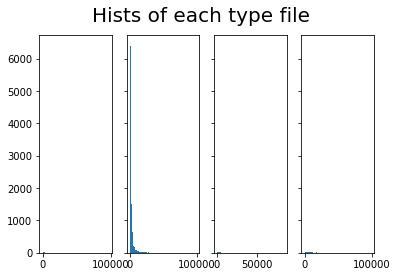

In [6]:
# 做直方图观察样本长度分布
tPlot, axes = plt.subplots(nrows=1, ncols=4, sharey=True)
tPlot.suptitle('Hists of each type file', fontsize=20)
axes[0].hist(c['len'], bins=100)
axes[1].hist(js['len'], bins=100)
axes[2].hist(java['len'], bins=100)
axes[3].hist(py['len'], bins=100)

In [7]:
# 其他三种文件分布均类似，但js不一样，所以对js部分做处理，以c的分布为标准，但保留500个样本
mx = max(js['len'])
mn = min(js['len'])
raw_len = len(js)
js = js.sample(frac=1)  # 打乱顺序
js_new = pd.DataFrame()
js_test = pd.DataFrame()
x_last = 0
for x in range(mn, mx, 10000):
    period_len = len(js.iloc[x_last:x, :])
    new_len = math.ceil(period_len/raw_len * 500)
    jsi = js.iloc[x_last:x, :].iloc[:new_len, :]
    jsi_test = js.iloc[x_last:x, :].iloc[new_len:, :]
    js_new = pd.concat([js_new, jsi])
    js_test = pd.concat([js_test, jsi_test])
    x_last = x
print(len(js_new))
print(len(js_test))

501
12750


(array([55., 36., 32., 26., 19., 19., 23., 20., 14., 18., 10., 13.,  8.,
         7.,  8.,  2.,  3., 11.,  6.,  8.,  3.,  3.,  4.,  3.,  2.,  4.,
         3.,  3.,  5.,  5.,  2.,  4.,  3.,  2.,  6.,  0.,  0.,  3.,  3.,
         3.,  4.,  2.,  3.,  3.,  3.,  2.,  1.,  3.,  3.,  2.,  1.,  1.,
         1.,  0.,  2.,  0.,  0.,  1.,  2.,  0.,  1.,  2.,  1.,  2.,  3.,
         2.,  0.,  0.,  2.,  1.,  0.,  2.,  0.,  2.,  0.,  2.,  1.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,
         1.,  1.,  1.,  2.,  0.,  0.,  0.,  1.,  1.]),
 array([  175.  ,  1158.15,  2141.3 ,  3124.45,  4107.6 ,  5090.75,
         6073.9 ,  7057.05,  8040.2 ,  9023.35, 10006.5 , 10989.65,
        11972.8 , 12955.95, 13939.1 , 14922.25, 15905.4 , 16888.55,
        17871.7 , 18854.85, 19838.  , 20821.15, 21804.3 , 22787.45,
        23770.6 , 24753.75, 25736.9 , 26720.05, 27703.2 , 28686.35,
        29669.5 , 30652.65, 31635.8 , 32618.95, 33602.1 , 34585.25,
        35568.4 , 36551.55

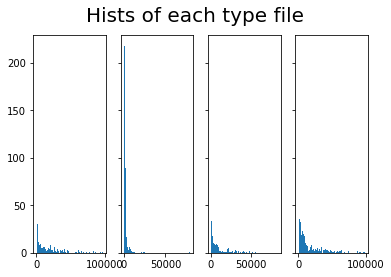

In [8]:
# 再次观察数据分布: js仍然略有偏，但由于原始数据集里根本没有过长的js脚本，无合适的处理办法
tPlot, axes = plt.subplots(nrows=1, ncols=4, sharey=True)
tPlot.suptitle('Hists of each type file', fontsize=20)
axes[0].hist(c['len'], bins=100)
axes[1].hist(js_new['len'], bins=100)
axes[2].hist(java['len'], bins=100)
axes[3].hist(py['len'], bins=100)

In [48]:
# 数据集的最终生成 & train、test划分 —— 8:2
train_set = pd.concat([c.iloc[:round(len(c)*0.8), :], js_new.iloc[:round(len(js)*0.8), :],
                       java.iloc[:round(len(java)*0.8), :], py.iloc[:round(len(py)*0.8), :]])
# 20% + js中剩余数据中随便抽取100个作为测试集（如果全部用来测试速度太慢）
test_set = pd.concat([c.iloc[round(len(c)*0.8):, :], js_new.iloc[round(len(js)*0.8):, :],
                      java.iloc[round(len(java)*0.8):, :], py.iloc[round(len(py)*0.8):, :],
                      js_test.iloc[:100, :]])
print(train_set.head(5))
print(test_set.head(5))
# 输出
train_set.to_csv('C:/Users/yangyujie8/PycharmProjects'
                 '/deep_learning/jianzhi/data/language_classifier_data/train_set.csv')
test_set.to_csv('C:/Users/yangyujie8/PycharmProjects'
                '/deep_learning/jianzhi/data/language_classifier_data/test_set.csv')

                                                   text type    len
2607  /* * IRQ offload/bypass manager * * Copyright ...    c   5849
2610  /* * Copyright (C) 2015, 2016 ARM Ltd. * * Thi...    c  13455
2614  /* * Copyright (C) 2017 ARM Ltd. * Author: Mar...    c  10305
2617  /* * Copyright (C) 2009, Steven Rostedt <srost...    c   5572
2620  /* * Copyright (C) 2009, Steven Rostedt <srost...    c   8572
                                                   text type    len
3421  #include <errno.h>#include <stdlib.h>#include ...    c   3759
3424  /* Copyright (c) 2016,2017 Facebook * * This p...    c   5396
3427  #include <linux/bpf.h>#include <linux/if_ether...    c   1194
3430  // SPDX-License-Identifier: GPL-2.0// Copyrigh...    c  19664
3433  /* Copyright (c) 2017 VMware * * This program ...    c    772


In [ ]:
# 分词: 对于编程语言的识别，标点符号反而很重要，比如各语言的注释符号不同，所以分词要小心，不能随便去停用词等
train_set = pd.read_csv('C:/Users/yangyujie8/PycharmProjects'
                        '/deep_learning/jianzhi/data/language_classifier_data/train_set.csv', index_col=0)
train_set['cuted_text'] = word_cut(train_set['text'])
train_set.to_csv('C:/Users/yangyujie8/PycharmProjects'
                 '/deep_learning/jianzhi/data/language_classifier_data/train_set_cuted.csv')

test_set = pd.read_csv('C:/Users/yangyujie8/PycharmProjects'
                       '/deep_learning/jianzhi/data/language_classifier_data/test_set.csv', index_col=0)
test_set['cuted_text'] = word_cut(test_set['text'])
test_set.to_csv('C:/Users/yangyujie8/PycharmProjects'
                '/deep_learning/jianzhi/data/language_classifier_data/test_set_cuted.csv')


In [ ]:
# 词频统计，过滤低频词 ===================================================================================================
train_set = pd.read_csv('C:/Users/yangyujie8/PycharmProjects'
                        '/deep_learning/jianzhi/data/language_classifier_data/train_set_cuted.csv', index_col=0)
test_set = pd.read_csv('C:/Users/yangyujie8/PycharmProjects'
                       '/deep_learning/jianzhi/data/language_classifier_data/test_set_cuted.csv', index_col=0)
train_x_count, word_set = one_hot_x(train_set['cuted_text'], ignore_num=1)
train_x_count.to_csv('C:/Users/yangyujie8/PycharmProjects'
                     '/deep_learning/jianzhi/data/language_classifier_data/train_x_count.csv')
test_x_count = one_hot_x(test_set['cuted_text'], word_set=word_set)
test_x_count.to_csv('C:/Users/yangyujie8/PycharmProjects'
                    '/deep_learning/jianzhi/data/language_classifier_data/test_x_count.csv')


In [5]:
train_x_one_hot = copy.deepcopy(train_x_count)
train_x_one_hot[train_x_one_hot >= 1] = 1
train_x_one_hot = train_x_one_hot.fillna(0)
test_x_one_hot = copy.deepcopy(test_x_count)
test_x_one_hot[test_x_one_hot >= 1] = 1
test_x_one_hot = test_x_one_hot.fillna(0)
pred_train_nb, pred_test_nb = naive_bayes(train_x_one_hot, train_set['type'], test_x_one_hot)
perfor_train_nb = performance(pred_train_nb, train_set['type'])
perfor_test_nb = performance(pred_test_nb, test_set['type'])
# 输出为json
nb_out = {'insample': perfor_train_nb, 'outsample': perfor_test_nb}
f = open('C:/Users/yangyujie8/PycharmProjects/deep_learning/jianzhi/out/language_classifier_out/nb_out.txt', 'w')
f.write(json.dumps(nb_out))
f.close()

In [ ]:

train_set['cuted_len'] = [len(i) for i in train_set['cuted_text']]
train_x_count_percent = (train_x_count.fillna(0).T/train_set['cuted_len'].values).T
test_set['cuted_len'] = [len(i) for i in test_set['cuted_text']]
test_x_count_percent = (test_x_count.fillna(0).T/test_set['cuted_len'].values).T
# 参数优化
keep_vars = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98]
out_dt_opt = {}
for v in keep_vars:
    train_x_count_pcai, test_x_count_pcai = pca(train_x_count_percent, test_x_count_percent, keep_var=v)
    pred_train_dti, pred_test_dti = decision_tree(train_x_count_pcai, test_x_count_pcai, train_set['type'],
                                                  max_d=20, max_f='sqrt')
    perfor_train_dti = performance(pred_train_dti, train_set['type'])
    perfor_test_dti = performance(pred_test_dti, test_set['type'])
    out_dt_opt['keep_val' + str(v)] = 'outsample accu: ' + str(perfor_test_dti['Overall_accuracy'])
f = open('C:/Users/yangyujie8/PycharmProjects/deep_learning/jianzhi/out/language_classifier_out/dt_out.txt', 'w')
f.write(json.dumps(out_dt_opt))
f.close()
# 最优参数结果
train_x_count_pca, test_x_count_pca = pca(train_x_count_percent, test_x_count_percent, keep_var=0.8)
# 决策树预测
pred_train_dt, pred_test_dt = decision_tree(train_x_count_pca, test_x_count_pca, train_set['type'],
                                            max_d=20, max_f='sqrt')
perfor_train_dt = performance(pred_train_dt, train_set['type'])
perfor_test_dt = performance(pred_test_dt, test_set['type'])
dt_out = {'insample': perfor_train_dt, 'outsample': perfor_test_dt}
f = open('C:/Users/yangyujie8/PycharmProjects/deep_learning/jianzhi/out/language_classifier_out/dt_out.txt', 'a')
f.write('\n')
f.write(json.dumps(dt_out))
f.close()


In [ ]:

train_set['cut_s'] = word_cut(train_set['text'], out='s')
test_set['cut_s'] = word_cut(test_set['text'], out='s')
train_x_wv, test_x_wv = word2vec(train_set['cut_s'], test_set['cut_s'], min_count=8, sg=1, vec_size=1000)

# 决策树预测
pred_train_wvdt, pred_test_wvdt = decision_tree(train_x_wv, test_x_wv, train_set['type'],
                                                max_d=50, max_f='sqrt')
perfor_train_wvdt = performance(pred_train_wvdt, train_set['type'])
perfor_test_wvdt = performance(pred_test_wvdt, test_set['type'])
wvdt_out = {'insample': perfor_train_wvdt, 'outsample': perfor_test_wvdt}
f = open('C:/Users/yangyujie8/PycharmProjects/deep_learning/jianzhi/out/language_classifier_out/wvdt_out.txt', 'w')
f.write(json.dumps(wvdt_out))
f.close()
